In [1]:
import json
import pickle
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob

pd.options.mode.chained_assignment = None
sns.set_style("darkgrid")

In [2]:
#### Settings
### Learning Rate for 2NN = 0.1, no learning rate decay
### Learning Rate for CNN = {0.01, 0.215/0.1 w/ clipnorm 1.0, 0.215/0.1 w/ clipnorm 2.0}, no learning rate decay

In [3]:
os.chdir("/home/bahy/research/icl-prelab-assignment/")

In [4]:
!pwd

/home/bahy/research/icl-prelab-assignment


In [5]:
datas = []
# for file_name in glob("logs_q2/lr0.215/*.txt") + glob("logs_q2/lr0.1/*.txt"):
for file_name in glob("logs_q2/lr0.215/cn2.0/*.txt"):
    if "untitled" in file_name:
        continue
    print(file_name)
    file = open(file_name, "rb")
    for data in file.readlines():
        if len(data) < 10: # Ignoring blank space/not useful information
            continue
        dict_data = eval(data)
        dict_data['setting'] = file_name.split("/")[3].split("-")[0]
        dict_data['model'] = file_name.split("/")[3].split("-")[-1].split(".")[0]
        if dict_data['model'] == "CNN":
            dict_data['E'] = 5
        else:
            dict_data['E'] = 1
        datas.append(dict_data)
        
datas = pd.DataFrame(datas)

logs_q2/lr0.215/cn2.0/NONIID-B10-C0.0-MNIST-CNN.txt
logs_q2/lr0.215/cn2.0/NONIID-B10-C0.1-MNIST-CNN.txt
logs_q2/lr0.215/cn2.0/IID-B600-C1.0-MNIST-CNN.txt
logs_q2/lr0.215/cn2.0/IID-B600-C0.0-MNIST-CNN.txt
logs_q2/lr0.215/cn2.0/IID-B10-C1.0-MNIST-CNN.txt
logs_q2/lr0.215/cn2.0/NONIID-B600-C0.1-MNIST-CNN.txt
logs_q2/lr0.215/cn2.0/IID-B10-C0.0-MNIST-CNN.txt
logs_q2/lr0.215/cn2.0/NONIID-B10-C1.0-MNIST-CNN.txt
logs_q2/lr0.215/cn2.0/IID-B600-C0.1-MNIST-CNN.txt
logs_q2/lr0.215/cn2.0/NONIID-B600-C0.0-MNIST-CNN.txt
logs_q2/lr0.215/cn2.0/IID-B10-C0.1-MNIST-CNN.txt


In [6]:
# Sort the data
ROUNDING_DIGIT = 4

df_metrics = datas.sort_values(by=['model', 'setting', 'B', 'C', 'E', 'comm_round']).reset_index(drop=True)
df_metrics['train_acc'] = df_metrics['train_acc'].apply(lambda x: round(x, ROUNDING_DIGIT))
df_metrics['test_acc'] = df_metrics['test_acc'].apply(lambda x: round(x, ROUNDING_DIGIT))
df_metrics['train_loss'] = df_metrics['train_loss'].apply(lambda x: round(x, ROUNDING_DIGIT))
df_metrics['test_loss'] = df_metrics['test_loss'].apply(lambda x: round(x, ROUNDING_DIGIT))
df_metrics.head()

,C,B,learning_rate,comm_round,train_acc,test_acc,train_loss,test_loss,setting,model,E
0,0.0,10,0.215,1,0.9208,0.9308,0.3262,0.2804,IID,CNN,5
1,0.0,10,0.215,2,0.9277,0.9341,0.3189,0.2852,IID,CNN,5
2,0.0,10,0.215,3,0.9524,0.9554,0.2084,0.1896,IID,CNN,5
3,0.0,10,0.215,4,0.9578,0.9593,0.1847,0.1692,IID,CNN,5
4,0.0,10,0.215,5,0.9582,0.9644,0.2019,0.1584,IID,CNN,5


In [7]:
df_metrics.shape

(7228, 11)

In [8]:
df_metrics.groupby(["model", "setting", "B", "C"]).size()

model  setting  B    C  
CNN    IID      10   0.0     660
                     0.1      26
                     1.0      25
                600  0.0     481
                     0.1     325
                     1.0     234
       NONIID   10   0.0    3256
                     0.1     779
                     1.0      97
                600  0.0     809
                     0.1     536
dtype: int64

In [9]:
df_metrics.groupby(["model", "setting", "B", "C"])['test_acc'].max()

model  setting  B    C  
CNN    IID      10   0.0    0.9903
                     0.1    0.9901
                     1.0    0.9904
                600  0.0    0.9900
                     0.1    0.9900
                     1.0    0.9893
       NONIID   10   0.0    0.9785
                     0.1    0.9900
                     1.0    0.9681
                600  0.0    0.9900
                     0.1    0.9901
Name: test_acc, dtype: float64

In [10]:
def make_monotonic(input_df, metric):
    input_df = input_df.reset_index(drop=True)
    
    if "acc" in metric:
        max_val = input_df[metric][0]
        keep = []

        for i in range(len(input_df)):
            current = input_df[metric][i]
            if max_val <= current:
                keep.append(input_df['comm_round'].index[i])
                max_val = current     
    else:
        min_val = input_df[metric][0]
        keep = []

        for i in range(len(input_df)):
            current = input_df[metric][i]
            if min_val >= current:
                keep.append(input_df['comm_round'].index[i])
                min_val = current
    
    return input_df.iloc[keep].reset_index(drop=True)

def fill_the_gap(input_df, round_to_achieve):
    if len(input_df) == round_to_achieve:
        return input_df
    
    initial_comm = input_df.tail(1)['comm_round'].values[0]
    for i in range(round_to_achieve - initial_comm):
        add_df = input_df.tail(1)
        add_df['comm_round'] = add_df['comm_round'] + 1
        input_df = input_df.append(add_df)
    
    return input_df.reset_index(drop=True)

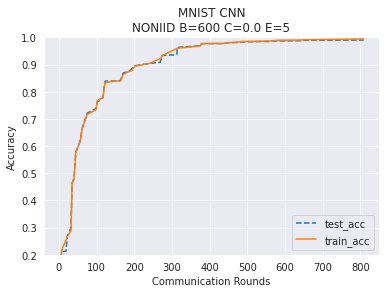

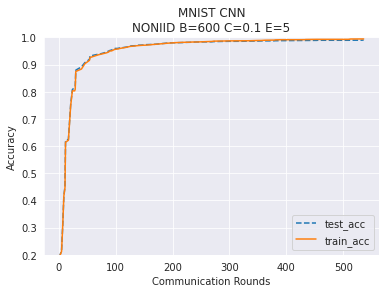

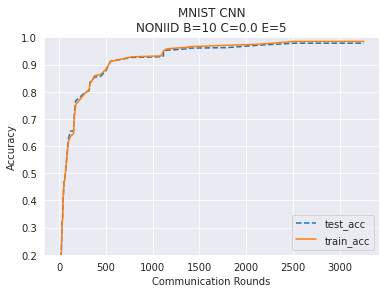

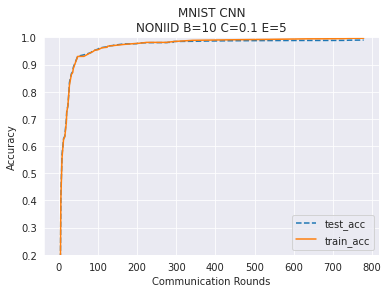

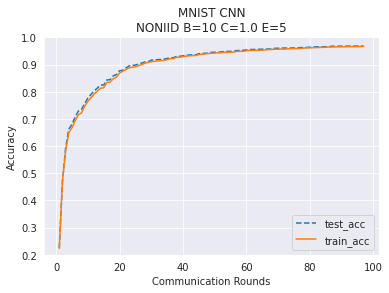

In [11]:
# Plot all accuracy and losses
MODELS = ["CNN"]
SETTINGS = ["NONIID"]
BATCHES = [600, 10]
C_FRACTIONS = [0.0, 0.1, 1.0]

for model in MODELS:
    for setting in SETTINGS:
        for b in BATCHES:
            for c in C_FRACTIONS:
                sample_df = df_metrics[(df_metrics['B']==b) & (df_metrics['C']==c)\
                                       & (df_metrics['setting']==setting) & (df_metrics['model']==model)]\
                                        .reset_index(drop=True)
                if len(sample_df) == 0:
                    continue
                styles = ['dashed', 'solid']
                metrics = ["test_acc", "train_acc"]
                max_len = len(sample_df)
                for i in range(2):
                    style, metric = styles[i], metrics[i]        
                    sample_df = make_monotonic(sample_df, metric)
                    sample_df = fill_the_gap(sample_df, max_len)

                    sns.lineplot(data=sample_df, x='comm_round', y=metric, label=metric, linestyle=style)

                plt.ylim(0.2, 1)
                plt.title("MNIST %s\n%s B=%s C=%s E=%s" % (model, setting, b, c, sample_df['E'].unique()[0]))
                plt.ylabel("Accuracy")
                plt.xlabel("Communication Rounds")
                plt.legend(loc='lower right')
                plt.savefig("logs_q2/lr0.215/cn2.0/MNIST %s\n%s B=%s C=%s E=%s_acc.jpg" % (model, setting, b, c, sample_df['E'].unique()[0]))
                plt.show()

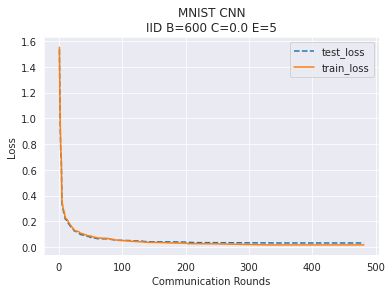

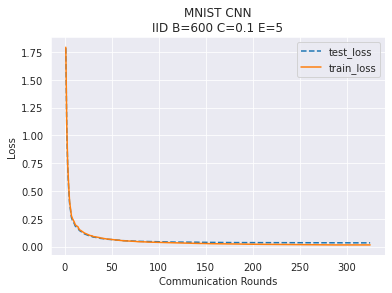

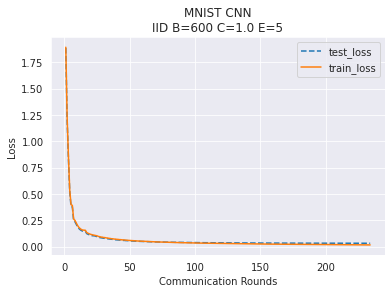

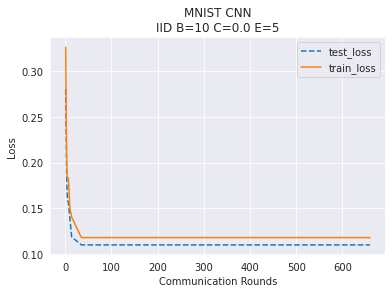

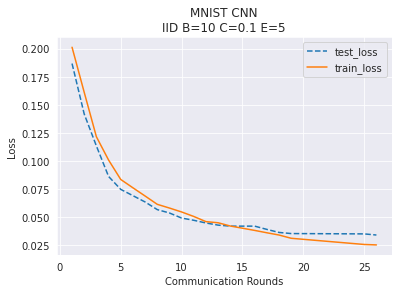

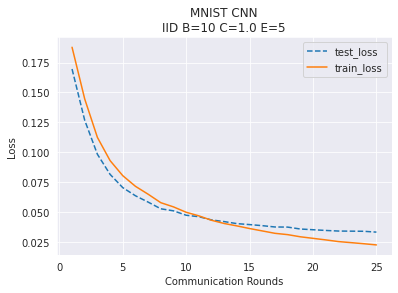

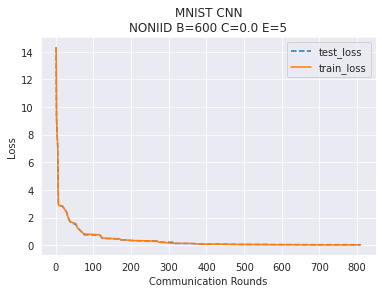

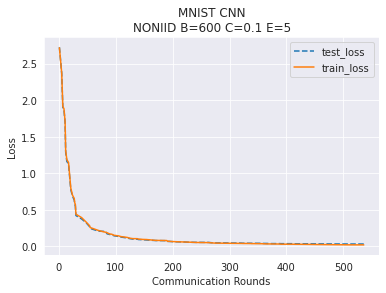

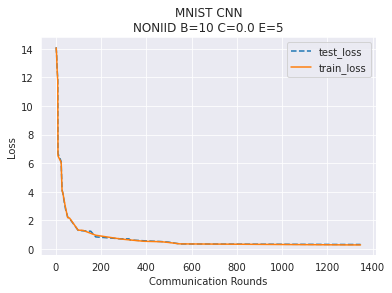

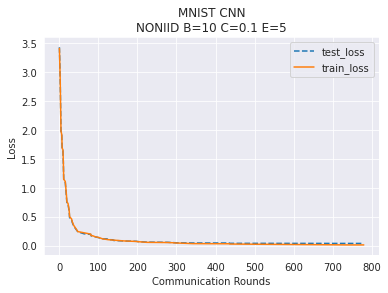

In [21]:
# Plot all accuracy and losses
MODELS = ["CNN"]
SETTINGS = ["IID", "NONIID"]
BATCHES = [600, 10]
C_FRACTIONS = [0.0, 0.1, 1.0]

for model in MODELS:
    for setting in SETTINGS:
        for b in BATCHES:
            for c in C_FRACTIONS:
                sample_df = df_metrics[(df_metrics['B']==b) & (df_metrics['C']==c)\
                                       & (df_metrics['setting']==setting) & (df_metrics['model']==model)]\
                                        .reset_index(drop=True)
                if len(sample_df) == 0:
                    continue
                styles = ['dashed', 'solid']
                metrics = ["test_loss", "train_loss"]
                max_len = len(sample_df)
                for i in range(2):
                    style, metric = styles[i], metrics[i]        
                    sample_df = make_monotonic(sample_df, metric)
                    sample_df = fill_the_gap(sample_df, max_len)

                    sns.lineplot(data=sample_df, x='comm_round', y=metric, label=metric, linestyle=style)

#                 plt.ylim(None, 0.2)
                plt.title("MNIST %s\n%s B=%s C=%s E=%s" % (model, setting, b, c, sample_df['E'].unique()[0]))
                plt.ylabel("Loss")
                plt.xlabel("Communication Rounds")
                plt.legend(loc='upper right')
                plt.savefig("logs_q2/lr0.215/cn2.0/MNIST %s\n%s B=%s C=%s E=%s_loss.jpg" % (model, setting, b, c, sample_df['E'].unique()[0]))
                plt.show()